In [1]:
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
from torch.utils.data import ConcatDataset, Dataset, DataLoader
import glob

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
file_path = {
    "2013_Targa_Sixty_Six": "data/2013_Targa_Sixty_Six",
    "2014_Targa_Sixty_Six": "data/2014_Targa_Sixty_Six",
    "2013_Laguna_Seca": "data/2013_Laguna_Seca",
}

In [4]:
dflist = []
for i, fname in enumerate(sorted(glob.glob("data/2013_Targa_Sixty_Six" + "/*.csv"))):
    dflist.append(pd.read_csv(fname, sep=","))

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class ApplyThreshold(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold, seq_length=1, threshold_as_upper_bound=False):
        self.threshold = threshold
        self.seq_length = seq_length
        self.threshold_as_upper_bound = threshold_as_upper_bound

    def fit(self, X, y=None):
        return self

    def _threshold_condition(self, df):
        if self.threshold_as_upper_bound:
            return df["vxCG"] < self.threshold
        else:
            return df["vxCG"] > self.threshold

    def _process_group(self, group):
        if len(group) > self.seq_length:
            return group

    def transform(self, dflist):
        new_dflist = []
        for df in dflist:
            df_mask = self._threshold_condition(df)
            groups = df[df_mask].groupby((~df_mask).cumsum())
            new_data = [self._process_group(group) for _, group in groups if self._process_group(group) is not None]
            new_dflist.extend(new_data)

        return new_dflist

In [33]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('threshold', ApplyThreshold(threshold=10, seq_length=10)),
])

new_df_list = pipeline.fit_transform(dflist)

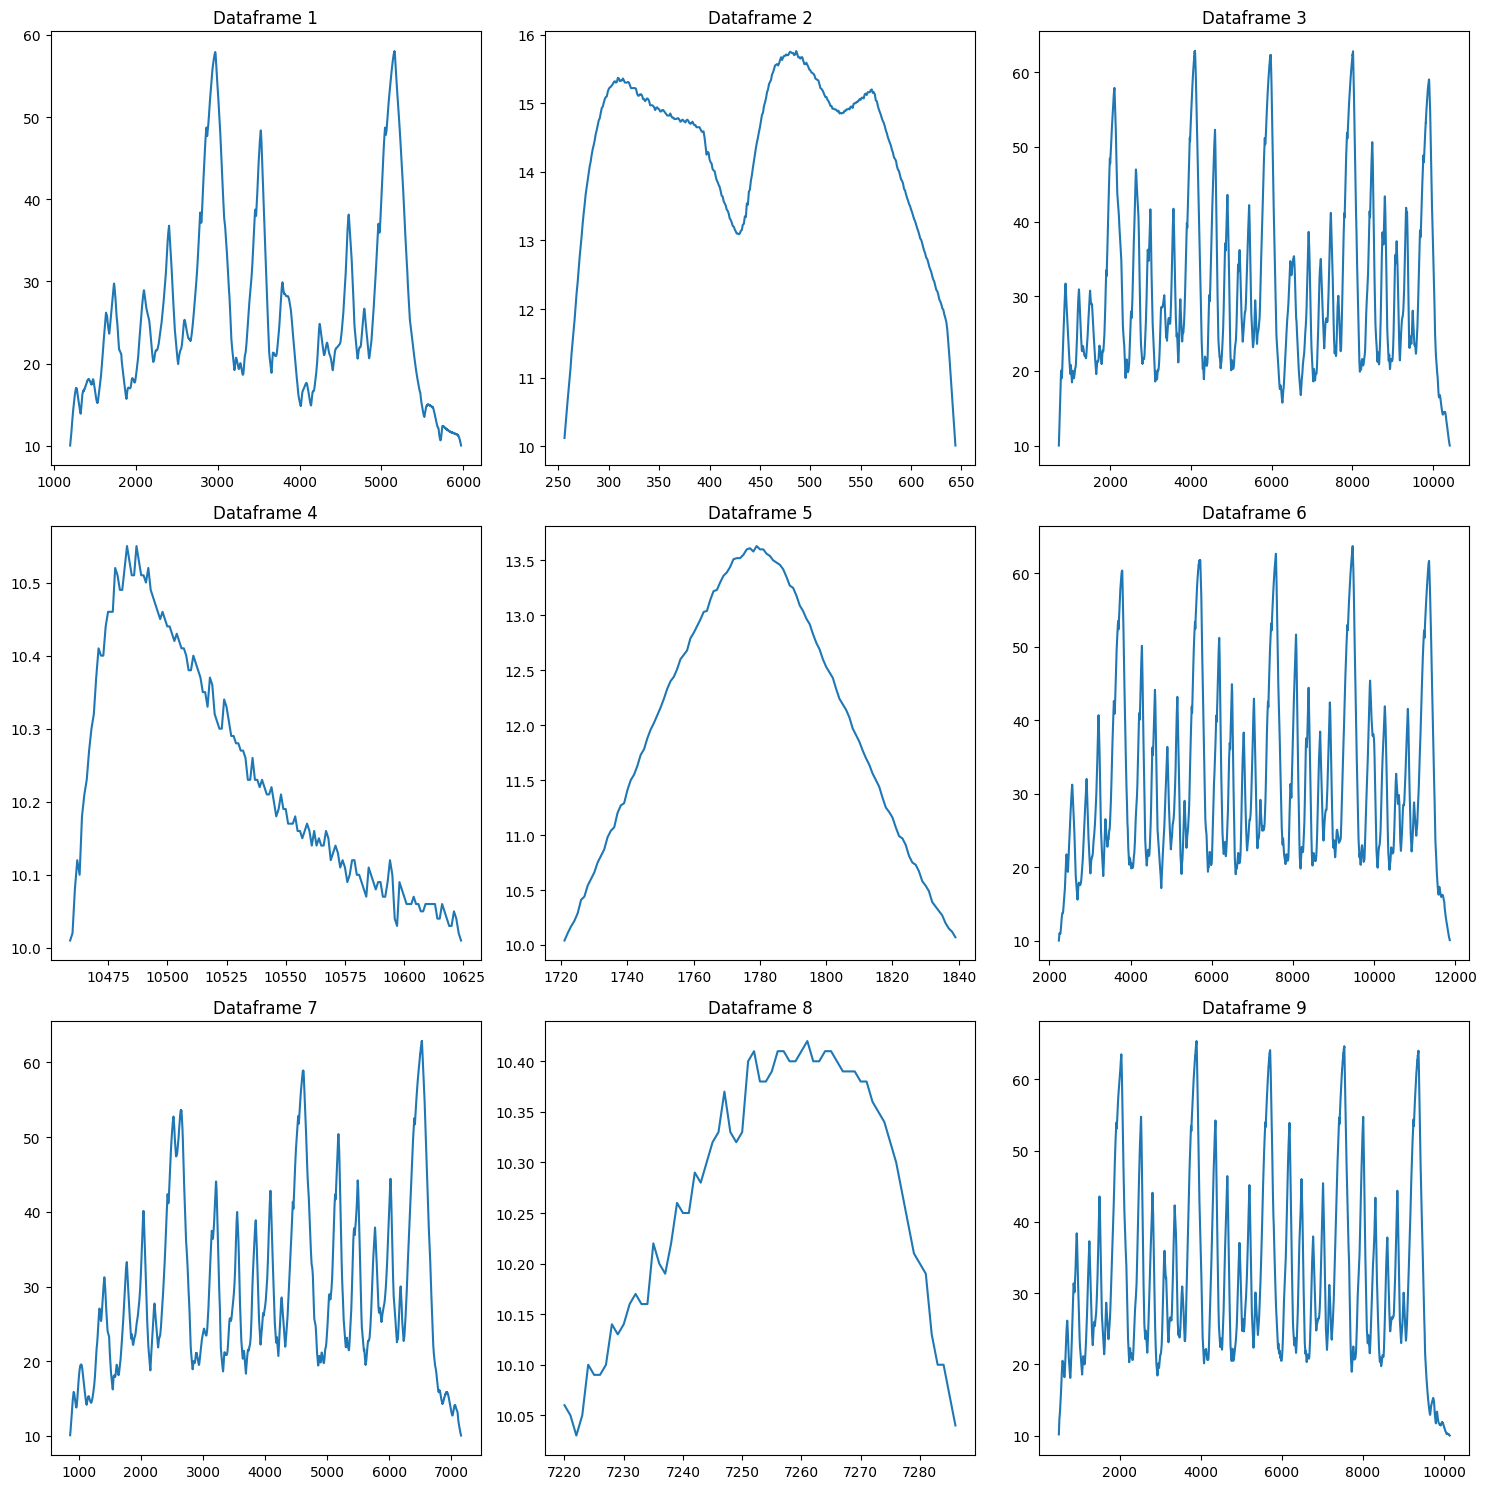

In [34]:
import matplotlib.pyplot as plt
import math

def plot_dataframes(df_list):
    n = len(df_list)
    sqrt_n = int(math.ceil(n**0.5))
    fig, axs = plt.subplots(sqrt_n, sqrt_n, figsize=(15, 15))

    for i, df in enumerate(df_list):
        ax = axs[i // sqrt_n, i % sqrt_n]
        df["vxCG"].plot(ax=ax)
        ax.set_title(f'Dataframe {i+1}')

    # Remove empty subplots
    if n < sqrt_n**2:
        for i in range(n, sqrt_n**2):
            fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()

plot_dataframes(new_df_list)

In [83]:
def threshold_condition(df, threshold, threshold_as_upper_bound=False):
    if threshold_as_upper_bound:
        return df["vxCG"] < threshold
    else:
        return df["vxCG"] > threshold
    
new_dflist = []
for df in dflist:
    df_mask = threshold_condition(df, threshold=10)
    groups = df[df_mask].groupby((~df_mask).cumsum())

<Axes: >

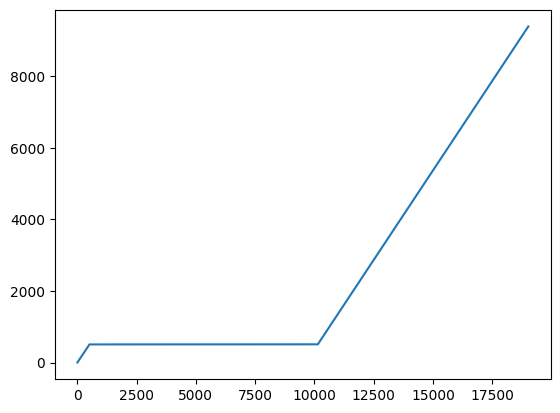

In [84]:
(~df_mask).cumsum().plot()

vxCG
505    Axes(0.125,0.11;0.775x0.77)
Name: vxCG, dtype: object

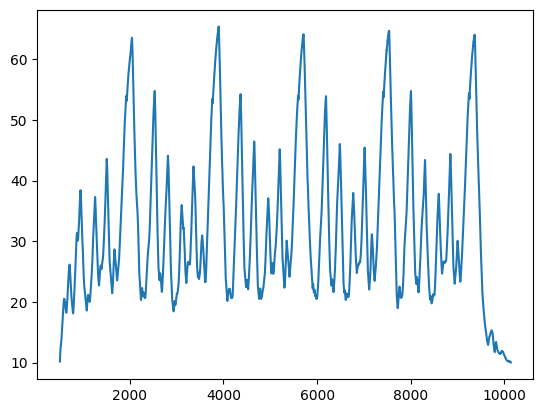

In [85]:
groups["vxCG"].plot()